In [678]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier,plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,roc_auc_score

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import ADASYN,SMOTE
%matplotlib inline


pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 500)

In [679]:
df = pd.read_csv('data/insurance_claims.csv')

In [680]:
df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,2015-02-22,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,2015-01-10,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,MALE,Associate,sales,board-games,unmarried,66000,-46000,2015-02-17,Vehicle Theft,?,Minor Damage,None,NY,Arlington,3041 3rd Ave,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [681]:
# missing value check

missing_stats = []

for col in df.columns:
    missing_stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0], df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))
    
stats_df = pd.DataFrame(missing_stats, columns=['feature', 'unique_values', 'percent_missing', 'percent_biggest_cat', 'type'])
stats_df.sort_values('percent_missing', ascending=False)


,feature,unique_values,percent_missing,percent_biggest_cat,type
0,months_as_customer,391,0.0,0.8,int64
29,witnesses,4,0.0,25.8,int64
22,incident_state,7,0.0,26.2,object
23,incident_city,7,0.0,15.7,object
24,incident_location,1000,0.0,0.1,object
25,incident_hour_of_the_day,24,0.0,5.4,int64
26,number_of_vehicles_involved,4,0.0,58.1,int64
27,property_damage,3,0.0,36.0,object
28,bodily_injuries,3,0.0,34.0,int64
30,police_report_available,3,0.0,34.3,object


In [682]:
df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.948000,546238.648000,1136.000000,1256.406150,1.101000e+06,501214.488000,25126.100000,-26793.700000,11.644000,1.83900,0.992000,1.487000,52761.94000,7433.420000,7399.570000,37928.950000,2005.103000
std,115.113174,9.140287,257063.005276,611.864673,244.167395,2.297407e+06,71701.610941,27872.187708,28104.096686,6.951373,1.01888,0.820127,1.111335,26401.53319,4880.951853,4824.726179,18886.252893,6.015861
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,0.000000,1.00000,0.000000,0.000000,100.00000,0.000000,0.000000,70.000000,1995.000000
25%,115.750000,32.000000,335980.250000,500.000000,1089.607500,0.000000e+00,448404.500000,0.000000,-51500.000000,6.000000,1.00000,0.000000,1.000000,41812.50000,4295.000000,4445.000000,30292.500000,2000.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,12.000000,1.00000,1.000000,1.000000,58055.00000,6775.000000,6750.000000,42100.000000,2005.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,17.000000,3.00000,2.000000,2.000000,70592.50000,11305.000000,10885.000000,50822.500000,2010.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,23.000000,4.00000,2.000000,3.000000,114920.00000,21450.000000,23670.000000,79560.000000,2015.000000


## Data Cleaning

Working with colums having date

In [683]:
#extracting out the year as policy_bind_year using regex

df['policy_bind_year'] = df['policy_bind_date'].str.extract('(\d{4})\-').astype('int')

In [684]:
#extracting out the month of incident from incident_date
#all accidents are from 2015 jan and feb

df['incident_month']=df['incident_date'].str.extract('\d{4}\-(\d{2})').astype('int')

There are some data with '?' as values. May be these data are not reported

In [685]:
unreported_cols = df.columns[df.isin(['?']).any()]

In [686]:
df[unreported_cols] = df[unreported_cols].replace('?','unreported')

In [687]:
print(df.columns[df.isin(['?']).any()])

Index([], dtype='object')


Feature like 'policy_deductable','witnesses','bodily_injuries','incident_severity' can be considered as categorical features

In [688]:
cat_var = ['policy_state','policy_csl','insured_sex','insured_education_level','insured_occupation',
           'insured_hobbies','insured_relationship','incident_type','collision_type','incident_severity',
           'authorities_contacted','incident_state','incident_city','property_damage','police_report_available',
           'auto_make','policy_bind_date','incident_date',
           'incident_location','insured_zip','auto_model','policy_number']
len(cat_var)

22

In [689]:
df[cat_var]

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make,policy_bind_date,incident_date,incident_location,insured_zip,auto_model,policy_number
0,OH,250/500,MALE,MD,craft-repair,sleeping,husband,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,YES,YES,Saab,2014-10-17,2015-01-25,9935 4th Drive,466132,92x,521585
1,IN,250/500,MALE,MD,machine-op-inspct,reading,other-relative,Vehicle Theft,unreported,Minor Damage,Police,VA,Riverwood,unreported,unreported,Mercedes,2006-06-27,2015-01-21,6608 MLK Hwy,468176,E400,342868
2,OH,100/300,FEMALE,PhD,sales,board-games,own-child,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,NO,NO,Dodge,2000-09-06,2015-02-22,7121 Francis Lane,430632,RAM,687698
3,IL,250/500,FEMALE,PhD,armed-forces,board-games,unmarried,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,unreported,NO,Chevrolet,1990-05-25,2015-01-10,6956 Maple Drive,608117,Tahoe,227811
4,IL,500/1000,MALE,Associate,sales,board-games,unmarried,Vehicle Theft,unreported,Minor Damage,None,NY,Arlington,NO,NO,Accura,2014-06-06,2015-02-17,3041 3rd Ave,610706,RSX,367455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,OH,500/1000,FEMALE,Masters,craft-repair,paintball,unmarried,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,YES,unreported,Honda,1991-07-16,2015-02-22,6045 Andromedia St,431289,Accord,941851
996,IL,100/300,FEMALE,PhD,prof-specialty,sleeping,wife,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,YES,unreported,Volkswagen,2014-01-05,2015-01-24,3092 Texas Drive,608177,Passat,186934
997,OH,250/500,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,unreported,YES,Suburu,2003-02-17,2015-01-23,7629 5th St,442797,Impreza,918516
998,IL,500/1000,MALE,Associate,handlers-cleaners,base-jumping,wife,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,unreported,YES,Audi,2011-11-18,2015-02-26,6128 Elm Lane,441714,A5,533940


In [690]:

len(df.columns)

41

In [691]:
df.rename(columns = {'capital-gains':'capital_gains','capital-loss':'capital_loss'}, inplace = True)

In [692]:
quan_var =['months_as_customer','policy_deductable','policy_annual_premium','vehicle_claim', 'capital_loss', 
           'number_of_vehicles_involved','injury_claim','capital_gains',
           'policy_bind_year','incident_month', 'property_claim', 'incident_hour_of_the_day',
           'umbrella_limit', 'age', 'total_claim_amount',
           'auto_year','witnesses','bodily_injuries']
print(len(quan_var))

18


In [693]:
df[quan_var]

,months_as_customer,policy_deductable,policy_annual_premium,vehicle_claim,capital_loss,number_of_vehicles_involved,injury_claim,capital_gains,policy_bind_year,incident_month,property_claim,incident_hour_of_the_day,umbrella_limit,age,total_claim_amount,auto_year,witnesses,bodily_injuries
0,328,1000,1406.91,52080,0,1,6510,53300,2014,1,13020,5,0,48,71610,2004,2,1
1,228,2000,1197.22,3510,0,1,780,0,2006,1,780,8,5000000,42,5070,2007,0,0
2,134,2000,1413.14,23100,0,3,7700,35100,2000,2,3850,7,5000000,29,34650,2007,3,2
3,256,2000,1415.74,50720,-62400,1,6340,48900,1990,1,6340,5,6000000,41,63400,2014,2,1
4,228,1000,1583.91,4550,-46000,1,1300,66000,2014,2,650,20,6000000,44,6500,2009,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,1000,1310.80,61040,0,1,17440,0,1991,2,8720,20,0,38,87200,2006,1,0
996,285,1000,1436.79,72320,0,1,18080,70900,2014,1,18080,23,0,41,108480,2015,3,2
997,130,500,1383.49,52500,0,3,7500,35100,2003,1,7500,4,3000000,34,67500,1996,3,2
998,458,2000,1356.92,36540,0,1,5220,0,2011,2,5220,2,5000000,62,46980,1998,1,0


In [694]:
#checking the all norminal data for large number of categories

for col in cat_var:
    print("###", col, "###" )
    print("  ")
    print(df[col].value_counts())
    print("---------------------------------------------")
    print("  ")

### policy_state ###
  
OH    352
IL    338
IN    310
Name: policy_state, dtype: int64
---------------------------------------------
  
### policy_csl ###
  
250/500     351
100/300     349
500/1000    300
Name: policy_csl, dtype: int64
---------------------------------------------
  
### insured_sex ###
  
FEMALE    537
MALE      463
Name: insured_sex, dtype: int64
---------------------------------------------
  
### insured_education_level ###
  
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: insured_education_level, dtype: int64
---------------------------------------------
  
### insured_occupation ###
  
machine-op-inspct    93
prof-specialty       85
tech-support         78
sales                76
exec-managerial      76
craft-repair         74
transport-moving     72
other-service        71
priv-house-serv      71
armed-forces         69
adm-clerical         65
protective-serv      63
han

1. "policy_bind_date" has 951 unique values for date and we have derived "policy_bind_year" from it.Hence, can be         dropped.
2. "insured_zip" has 995 unique values.
3. "policy_number" is unique for all records. Serves as id cor the policies. Hence, can be dropped.
4. "incident_date" has a lot of unique values. We have derived "incident_month" from this feature. Hence this can be       dropped
5. "incident_location" has all unique values in feature.

In [695]:
large_cat=['policy_bind_date','incident_date','incident_location','insured_zip','auto_model','policy_number']
df.drop(large_cat, axis=1, inplace=True)

In [696]:
#redefining the norminal var
#remove target feature from the list

cat_var = (list(set(cat_var) - set(large_cat))) 
len(cat_var)

16

In [697]:
print ('total var count:{}'.format(len(list(df.columns))),
       'quantitative var count:{}'.format(len(quan_var)),
       'categorical var count:{}'.format(len(cat_var)))

total var count:35 quantitative var count:18 categorical var count:16


In [698]:
neg_val = df[df.umbrella_limit < 0].index

In [699]:
df.iloc[neg_val] = -1 * df.iloc[neg_val]

In [700]:
df[df.umbrella_limit < 0]

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_gains,capital_loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,policy_bind_year,incident_month


In [701]:
df['umbrella_limit'].value_counts()

0           798
6000000      57
5000000      46
4000000      39
7000000      29
3000000      12
8000000       8
9000000       5
2000000       3
10000000      2
1000000       1
Name: umbrella_limit, dtype: int64

In [702]:
df['fraud_reported'].value_counts()

N    752
Y    247
       1
Name: fraud_reported, dtype: int64

In [703]:
df[df['fraud_reported'] == ""].index

Int64Index([290], dtype='int64')

In [704]:
df.drop(df.index[290],  inplace = True)

In [705]:
df.reset_index(inplace = True, drop = True)

In [706]:
df['fraud_reported'] = df['fraud_reported'].map({"Y":1, "N":0})


In [707]:
df[df['fraud_reported'].isnull()]

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_gains,capital_loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,policy_bind_year,incident_month


In [708]:
df

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_gains,capital_loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,policy_bind_year,incident_month
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,2004,1,2014,1
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,unreported,Minor Damage,Police,VA,Riverwood,8,1,unreported,0,0,unreported,5070,780,780,3510,Mercedes,2007,1,2006,1
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,2007,0,2000,2
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,unreported,1,2,NO,63400,6340,6340,50720,Chevrolet,2014,1,1990,1
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,unreported,Minor Damage,None,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,2009,0,2014,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,3,38,OH,500/1000,1000,1310.80,0,FEMALE,Masters,craft-repair,paintball,unmarried,0,0,Single Vehicle Collision,Front Collision,Minor Damage,Fire,NC,Northbrook,20,1,YES,0,1,unreported,87200,17440,8720,61040,Honda,2006,0,1991,2
995,285,41,IL,100/300,1000,1436.79,0,FEMALE,PhD,prof-specialty,sleeping,wife,70900,0,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Northbend,23,1,YES,2,3,unreported,108480,18080,18080,72320,Volkswagen,2015,0,2014,1
996,130,34,OH,250/500,500,1383.49,3000000,FEMALE,Masters,armed-forces,bungie-jumping,other-relative,35100,0,Multi-vehicle Collision,Side Collision,Minor Damage,Police,NC,Arlington,4,3,unreported,2,3,YES,67500,7500,7500,52500,Suburu,1996,0,2003,1
997,458,62,IL,500/1000,2000,1356.92,5000000,MALE,Associate,handlers-cleaners,base-jumping,wife,0,0,Single Vehicle Collision,Rear Collision,Major Damage,Other,NY,Arlington,2,1,unreported,0,1,YES,46980,5220,5220,36540,Audi,1998,0,2011,2


# Exploratory Data Analysis

In [709]:
df.fraud_reported.value_counts()

0    752
1    247
Name: fraud_reported, dtype: int64

<AxesSubplot:>

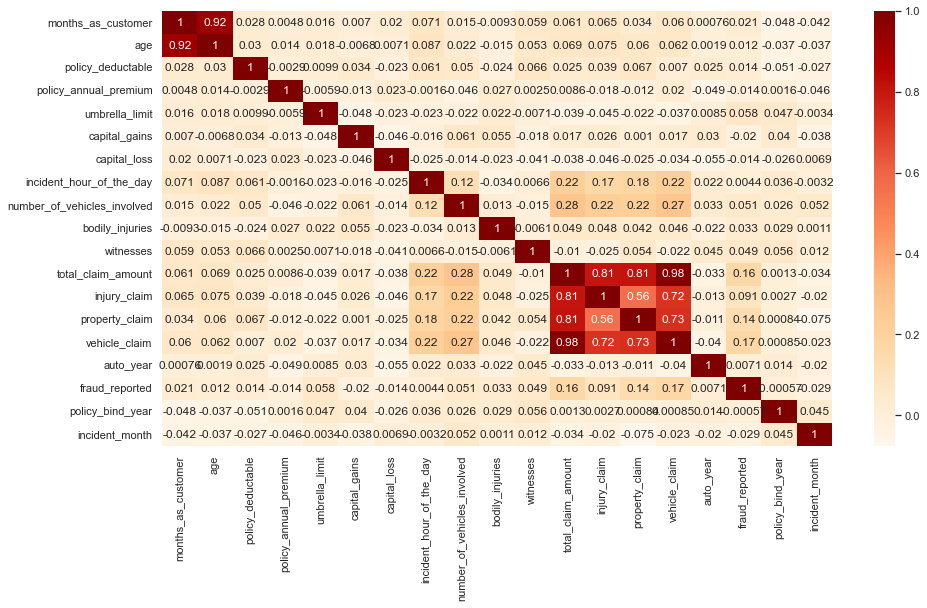

In [710]:
#Finding correlations between features
corr = df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, annot=True, cmap='OrRd')

'age','months_as_customer','total_claim_amount','vehicle_claim','property_claim''injury_claim are highly correlated

In [711]:
#Total_claim_amount is sum of injury_claim, property_claim, vehicle_claim and can be dropped.
#age feature is highly correlated with months_as_customer and can be dropped

df.drop(['age','total_claim_amount'], axis=1, inplace=True)
df.reset_index(inplace = True, drop = True)

In [712]:
len(df.columns)

33

<AxesSubplot:>

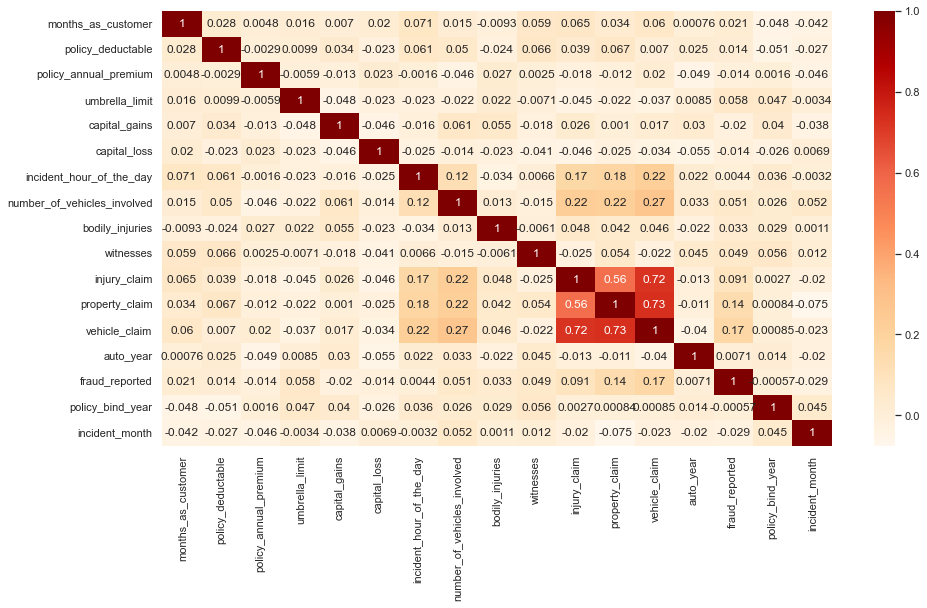

In [713]:
corr = df.corr()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(corr, annot=True, cmap='OrRd')

In [714]:
quan_var = (list(set(quan_var) - set(['age','total_claim_amount']))) 
len(quan_var)

16

In [716]:
cat_var

['property_damage',
 'policy_csl',
 'collision_type',
 'incident_state',
 'authorities_contacted',
 'policy_state',
 'insured_occupation',
 'incident_city',
 'auto_make',
 'insured_sex',
 'insured_education_level',
 'incident_severity',
 'insured_hobbies',
 'police_report_available',
 'incident_type',
 'insured_relationship']

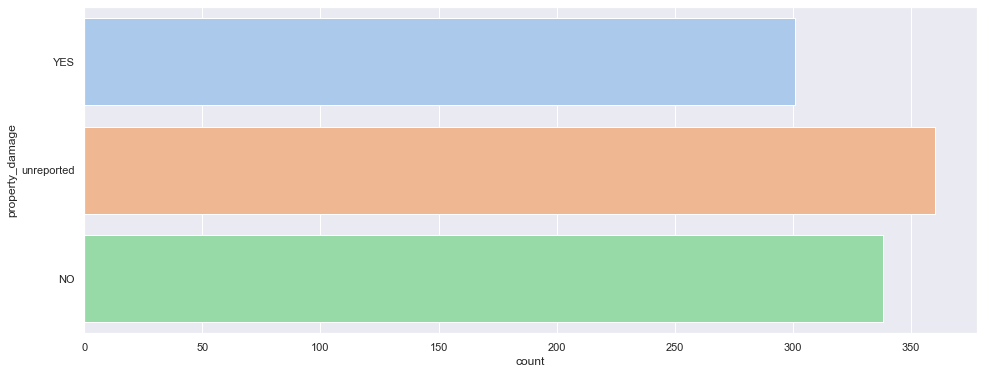

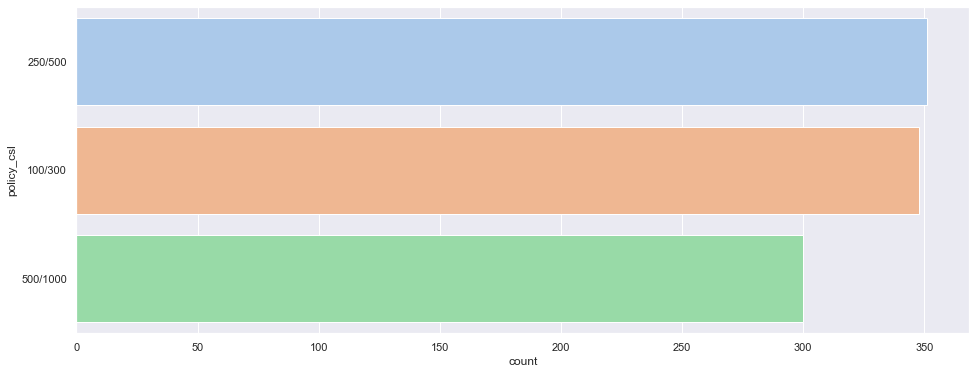

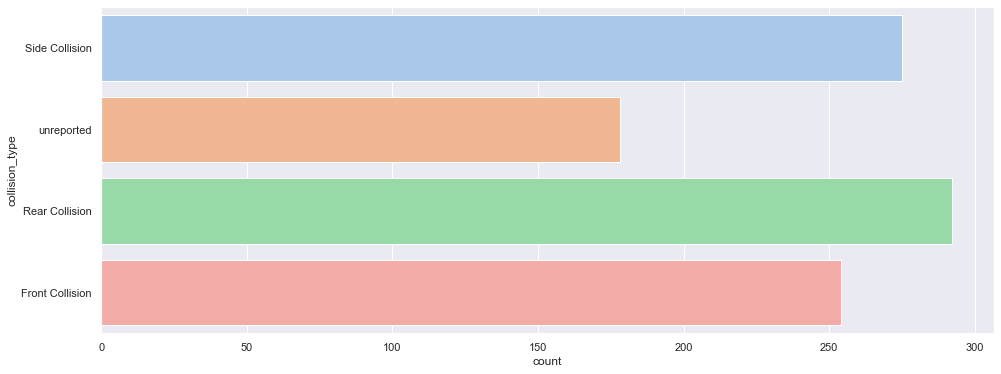

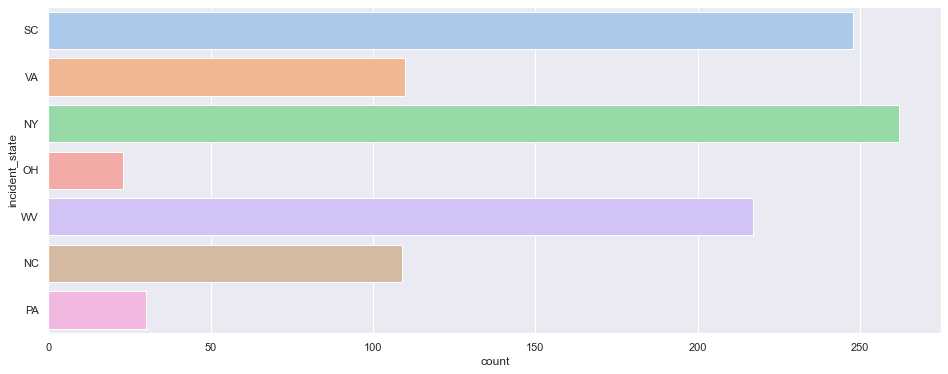

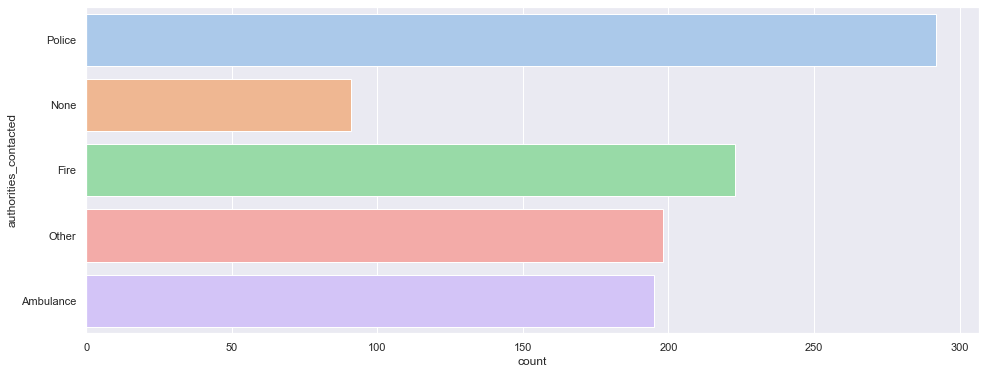

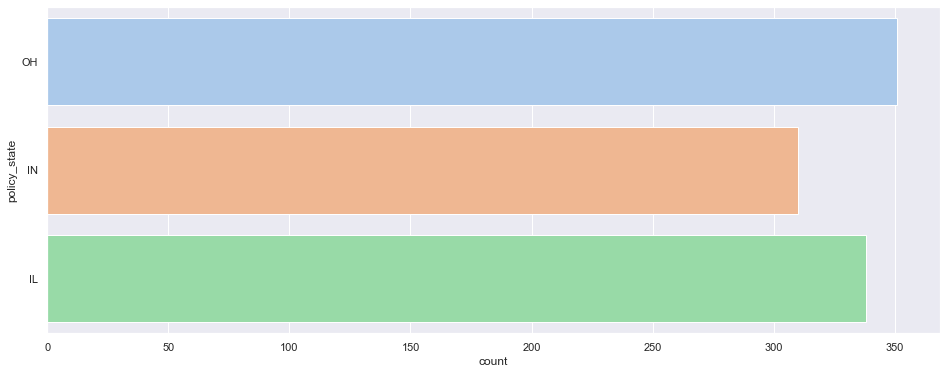

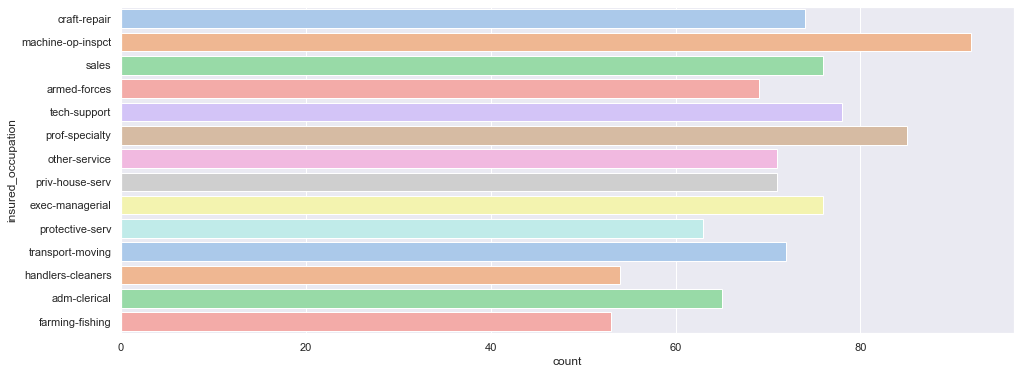

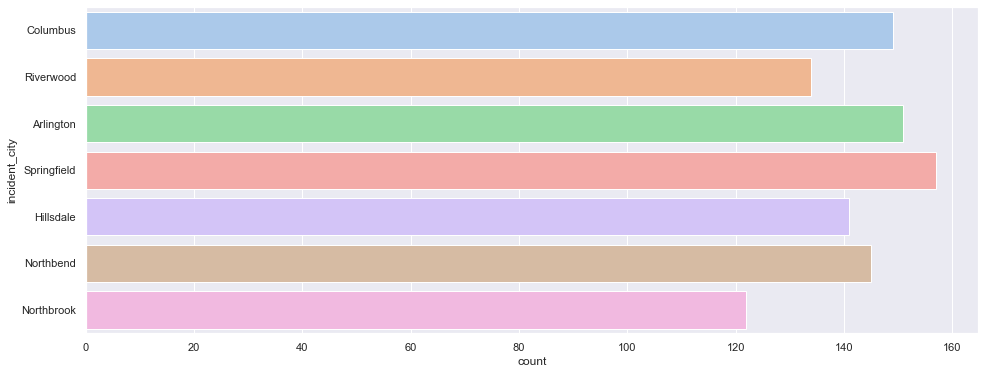

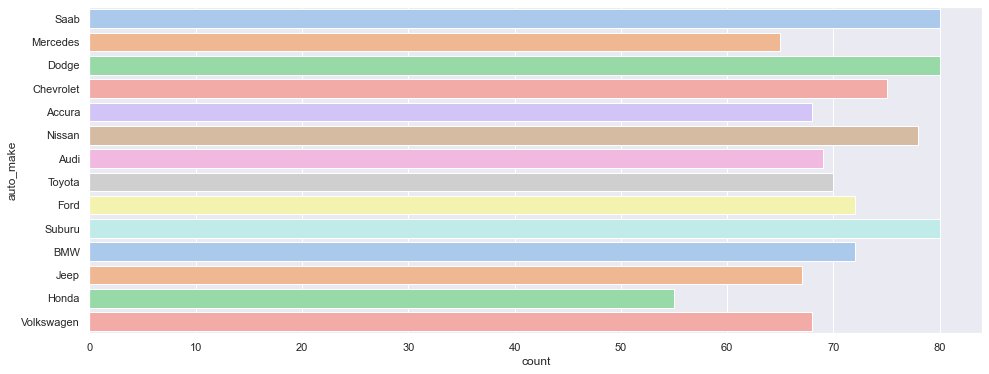

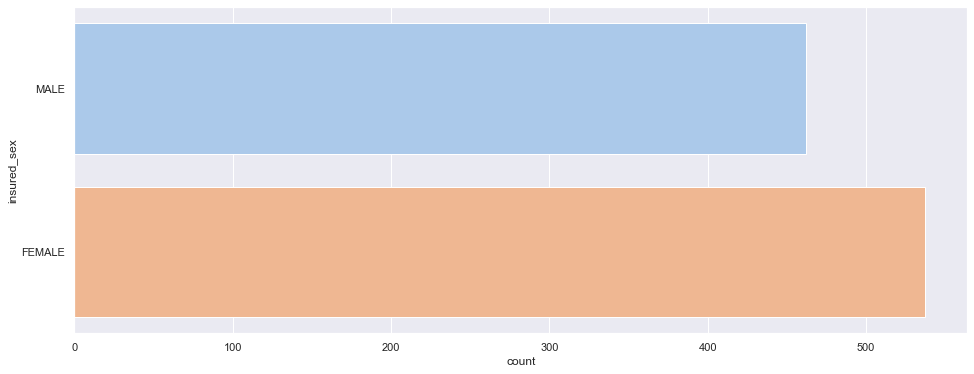

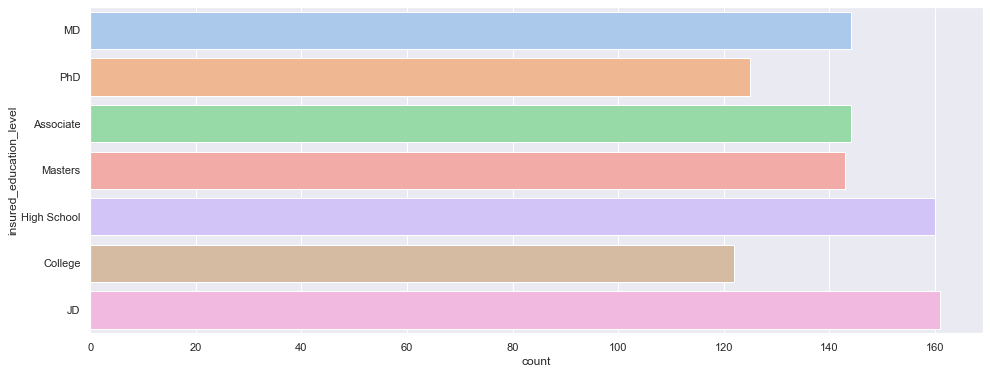

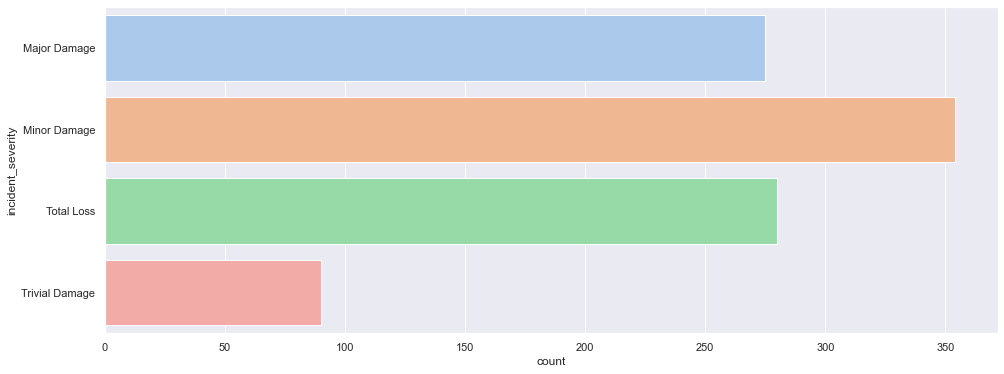

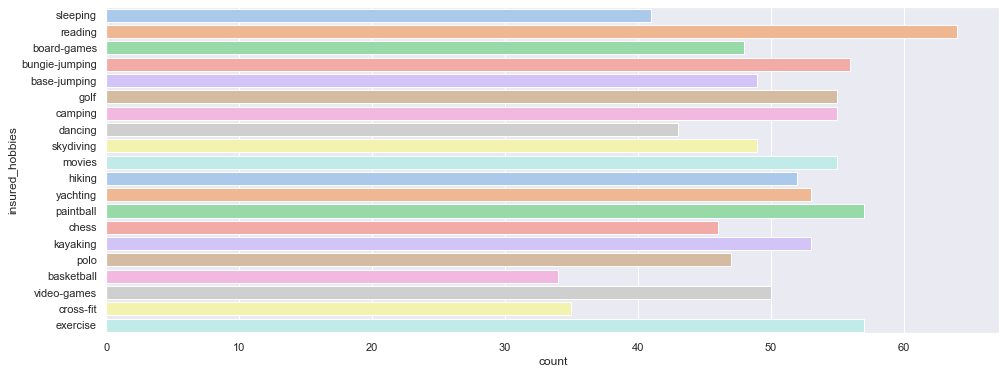

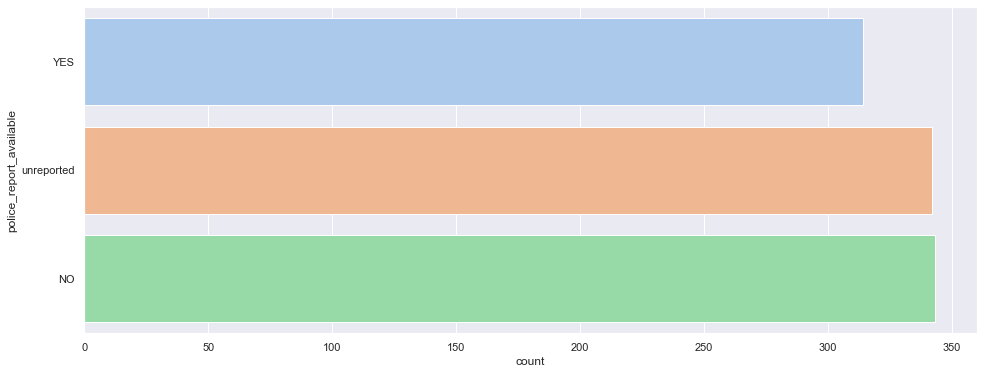

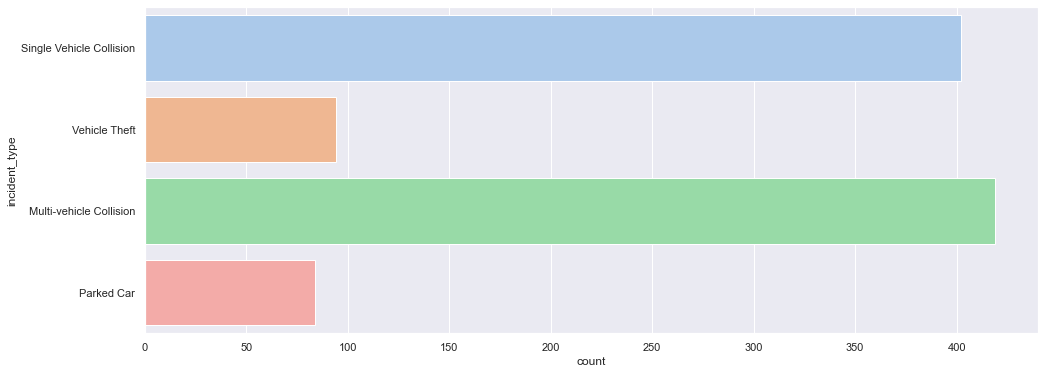

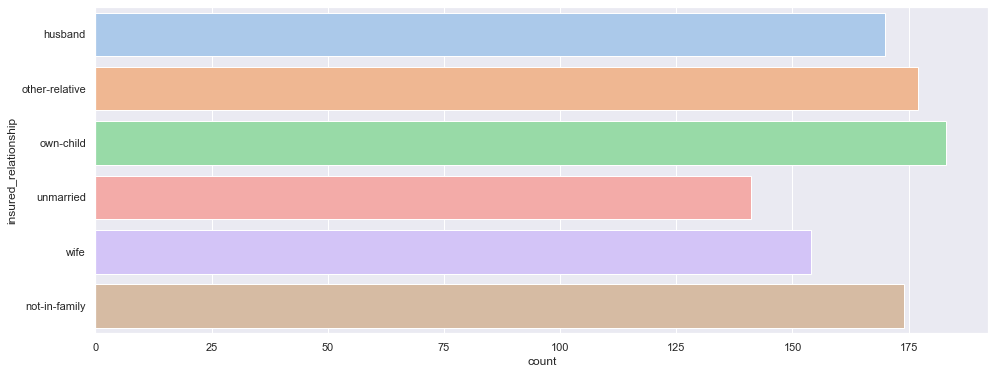

In [717]:
#countplot of categorical var , 

for i, name in enumerate(df[cat_var]):
    plt.figure(i,figsize=(16,6))
    sns.countplot(y=name, data=df[cat_var], palette="pastel")

1. Authorities_contacted: Police are the most frequently contacted followed by the fire brigades.
1. Auto_make: apart from Honda (least), most are relatively even.
3. Collision_type: the distribution looks evenly spread across the categories. Most are rear collisions. Smallest        groups are the undocumented collisions. we can explore which collisions will be the most expensive and have the        most frauds.
4. Incident_city: relatively even with Springfield and Arlington being the highest.
5. Incident_type: very few incidents are by theft/parked car. Most are by multivehicle collision and single vehicle      collision. We can explore how claims and fraud differ across them.
6. Property_damage: relatively even but undocumented damage has the highest numbers

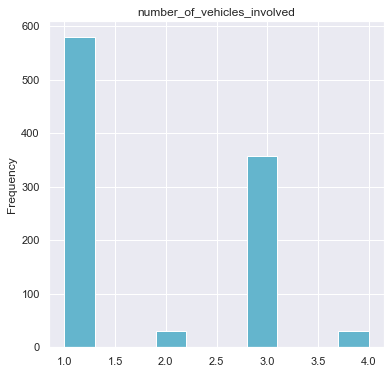

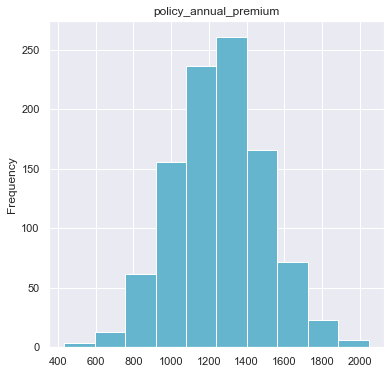

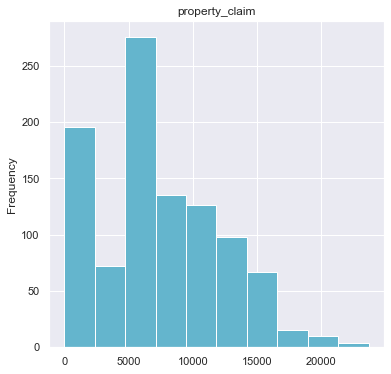

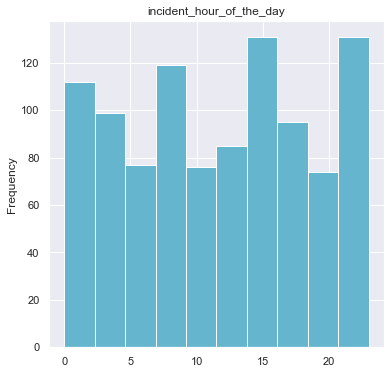

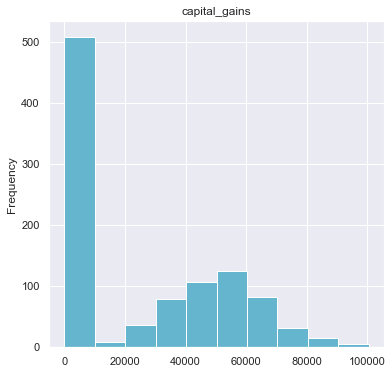

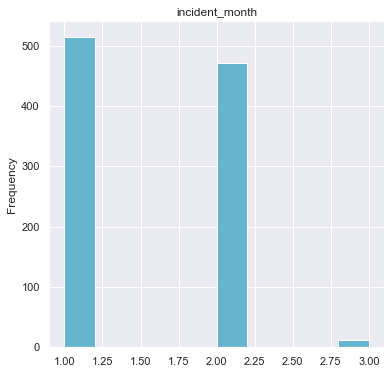

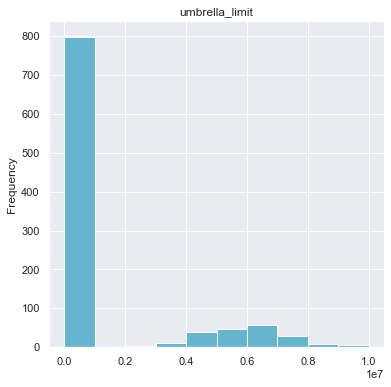

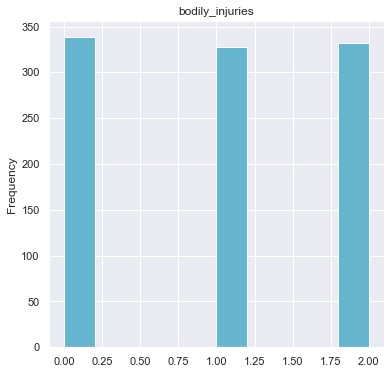

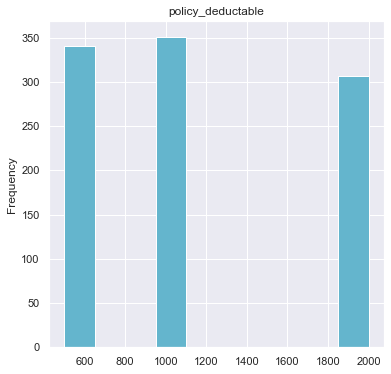

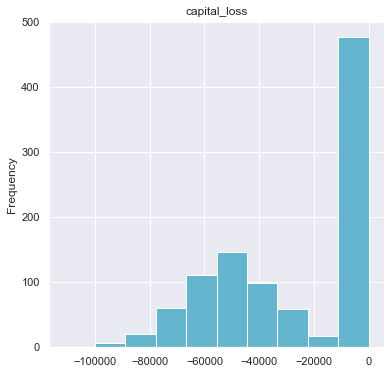

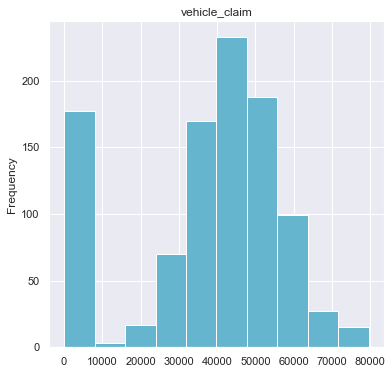

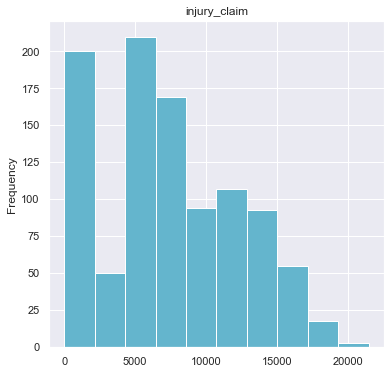

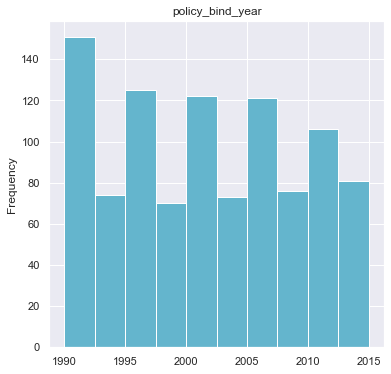

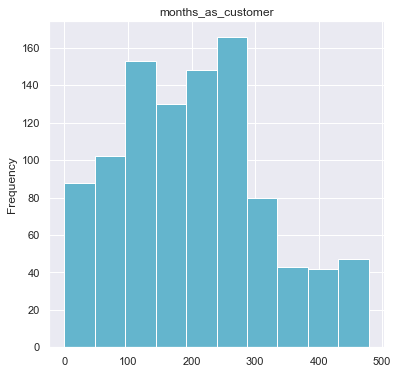

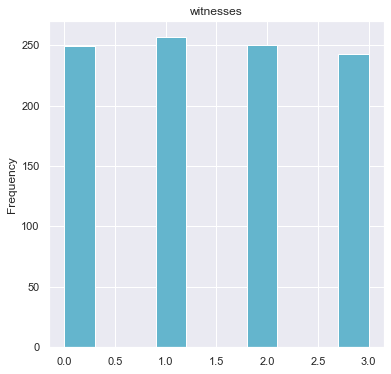

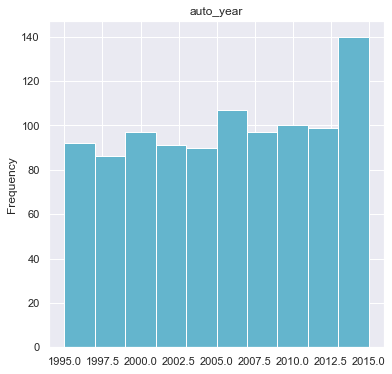

In [720]:
#distribution of ordinal and continuous variables

for i, name in enumerate(df[quan_var]):
    plt.figure(i,figsize=(6,6))
    df[name].plot(kind="hist", color="c", title=name)

Continuous variables' counts were visualized with bar plots. I sum up some observations in point:

1. <b>policy annual premium:</b> looks like a normal distribution.
2. <b>policy bind years:</b> have staggering frequencies with some range of years more popular than others. This may be some    auto market cycle. 1990 to 2992 is the highest.
3. <b>capital gain and loss:</b> are mostly 0

In [607]:
df[quan_var].head()

,number_of_vehicles_involved,policy_annual_premium,property_claim,incident_hour_of_the_day,capital_gains,incident_month,umbrella_limit,bodily_injuries,policy_deductable,capital_loss,vehicle_claim,injury_claim,policy_bind_year,months_as_customer,witnesses,auto_year
0,1,1406.91,13020,5,53300,1,0,1,1000,0,52080,6510,2014,328,2,2004
1,1,1197.22,780,8,0,1,5000000,0,2000,0,3510,780,2006,228,0,2007
2,3,1413.14,3850,7,35100,2,5000000,2,2000,0,23100,7700,2000,134,3,2007
3,1,1415.74,6340,5,48900,1,6000000,1,2000,-62400,50720,6340,1990,256,2,2014
4,1,1583.91,650,20,66000,2,6000000,0,1000,-46000,4550,1300,2014,228,1,2009


In [608]:
df[cat_var].head()

,property_damage,policy_csl,collision_type,incident_state,authorities_contacted,policy_state,insured_occupation,incident_city,auto_make,insured_sex,insured_education_level,incident_severity,insured_hobbies,police_report_available,incident_type,insured_relationship
0,YES,250/500,Side Collision,SC,Police,OH,craft-repair,Columbus,Saab,MALE,MD,Major Damage,sleeping,YES,Single Vehicle Collision,husband
1,unreported,250/500,unreported,VA,Police,IN,machine-op-inspct,Riverwood,Mercedes,MALE,MD,Minor Damage,reading,unreported,Vehicle Theft,other-relative
2,NO,100/300,Rear Collision,NY,Police,OH,sales,Columbus,Dodge,FEMALE,PhD,Minor Damage,board-games,NO,Multi-vehicle Collision,own-child
3,unreported,250/500,Front Collision,OH,Police,IL,armed-forces,Arlington,Chevrolet,FEMALE,PhD,Major Damage,board-games,NO,Single Vehicle Collision,unmarried
4,NO,500/1000,unreported,NY,None,IL,sales,Arlington,Accura,MALE,Associate,Minor Damage,board-games,NO,Vehicle Theft,unmarried


# Modelling

In [609]:
# define preprocessing pipeline
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, quan_var),
        ("cat", categorical_transformer, cat_var)
    ]
)

In [610]:
x = df.drop('fraud_reported', axis=1)
y = df['fraud_reported']

In [611]:
df[df['fraud_reported'].isnull()]

,months_as_customer,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital_gains,capital_loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,injury_claim,property_claim,vehicle_claim,auto_make,auto_year,fraud_reported,policy_bind_year,incident_month


In [612]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

In [613]:
x_train = preprocessor.fit_transform(x_train)

In [614]:
x_test = preprocessor.transform(x_test)

In [718]:
# Utility
def get_scores(t, name):
  """
  This function help print all the metrics  
  """
  print (name, 'classification metric')
  print("CV scores:", round(t.best_score_,3))
  print("train score:", round(t.score(x_train, y_train),3))
  print("test score:", round(t.score(x_test, y_test),3))

  #Evaluation metrics
  predictions = t.best_estimator_.predict(x_test)

  TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

  sensi = TP/(TP + FN)
  speci= TN/(TN + FP)
  preci = TP/(TP + FP)
  f1= 2*(preci*sensi)/(preci+sensi)

  print(f'Sensitivity: {round(sensi,3)}')
  print(f'Specificity: {round(speci,3)}')
  print(f'Precision: {round(preci,3)}')
  print(f'F1: {round(f1,3)}')

  pred_proba = [i[1] for i in t.predict_proba(x_test)]
  auc_score = roc_auc_score(y_test, pred_proba)
  print('ROC AUC Score:', round(auc_score,3))

### Logistic Regression

In [616]:
y_train.value_counts(normalize=True)

0    0.753004
1    0.246996
Name: fraud_reported, dtype: float64

In [617]:

lr = LogisticRegression(max_iter=200)

lr_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            'class_weight':[{0:0.246667, 1:0.75333},None]}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)    
rs_lr = RandomizedSearchCV(lr, lr_values, cv=cv, n_jobs = -1, random_state=42)
rs_lr.fit(x_train, y_train)
print(rs_lr.best_params_)
get_scores(rs_lr,'Logistic regression')

{'solver': 'liblinear', 'penalty': 'l2', 'class_weight': None, 'C': 5.1794746792312125}
Logistic regression classification metric
CV scores: 0.821
train score: 0.904
test score: 0.828
Sensitivity: 0.581
Specificity: 0.91
Precision: 0.679
F1: 0.626
ROC AUC Score: 0.827


### Random Forest

In [618]:
rf = RandomForestClassifier(n_jobs=-1)

rf_values = {'max_depth': [10, 20, 30, 40, 50, 60],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'class_weight':[{0:0.246667, 1:0.75333},None],
             'oob_score' : 'TRUE'
              }

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)    
rs_rf = RandomizedSearchCV(rf, rf_values, cv=cv, n_jobs = -1, random_state=42)
rs_rf.fit(x_train, y_train)
print(rs_rf.best_params_)
get_scores(rs_rf,'Random forest')

{'oob_score': 'R', 'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 40, 'class_weight': {0: 0.246667, 1: 0.75333}}
Random forest classification metric
CV scores: 0.811
train score: 0.876
test score: 0.808
Sensitivity: 0.661
Specificity: 0.856
Precision: 0.603
F1: 0.631
ROC AUC Score: 0.836


### XGBoost

In [619]:
#scale_pos_weight = total_negative_examples / total_positive_examples
y_train.value_counts()[0]/y_train.value_counts()[1]

3.0486486486486486

In [620]:
xg = XGBClassifier(booster='gbtree', n_jobs=-1, use_label_encoder=False)

xg_values = {'max_depth': [3, 4, 5, 6],
             'eta': [0.05, 0.1, 0.15, 0.3],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0, 1, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'scale_pos_weight':[1, 3.0486486486486486],
              }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)   
rs_xg = RandomizedSearchCV(xg, xg_values, cv=cv, n_jobs = -1, random_state=42)
rs_xg.fit(x_train, y_train)
print(rs_xg.best_params_)

[02:22:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'scale_pos_weight': 3.0486486486486486, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 550, 'max_depth': 6, 'gamma': 3, 'eta': 0.05}


In [621]:
get_scores(rs_xg,'XGBoost')

XGBoost classification metric
CV scores: 0.842
train score: 0.981
test score: 0.844
Sensitivity: 0.758
Specificity: 0.872
Precision: 0.662
F1: 0.707
ROC AUC Score: 0.847


As we are working on imbalanced dataset, Lets balance the data by using SMOTE

### Data Balancing usig SMOTE

0    564
1    564
Name: fraud_reported, dtype: int64


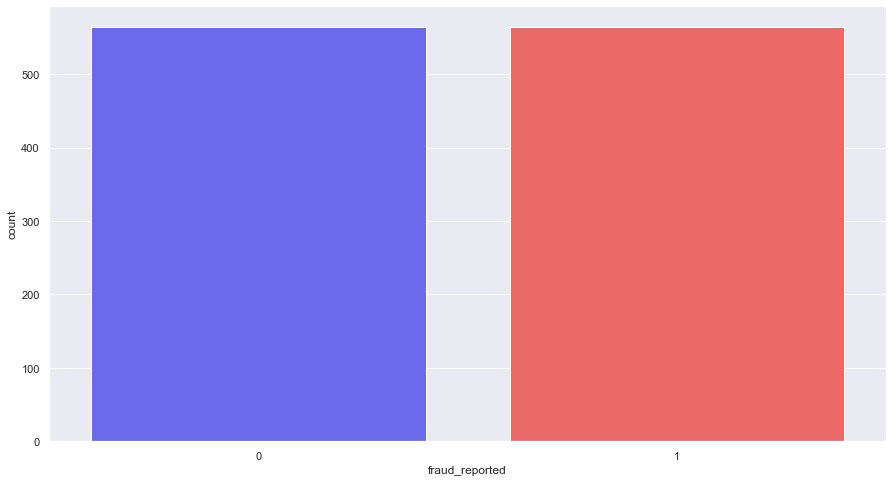

In [622]:
oversample = SMOTE()
x_train, y_train = oversample.fit_resample(x_train, y_train)
print(y_train.value_counts())

sns.countplot(x=y_train, palette='seismic');

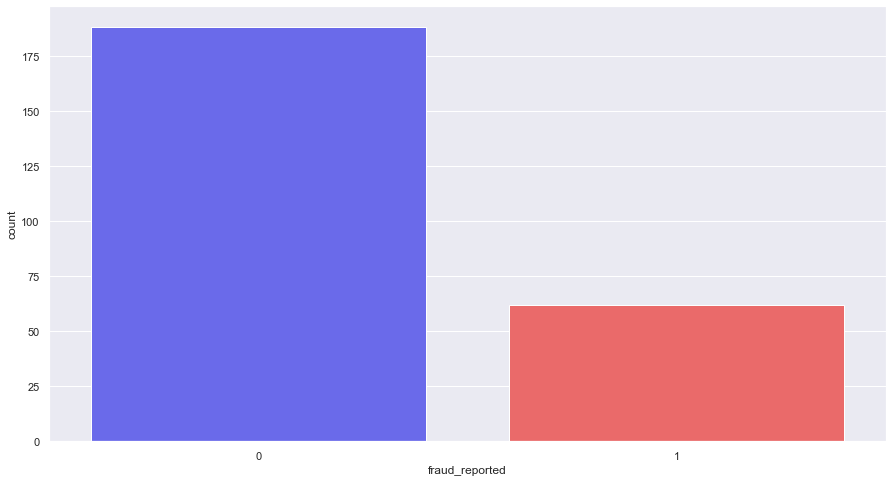

In [623]:
sns.countplot(x=y_test, palette='seismic');

### Logistic Regression after SMOTE

In [624]:
lr2 = LogisticRegression(max_iter=200)

lr2_values = {'solver': ['liblinear'],
            'penalty': ['l1', 'l2'],
            'C': np.logspace(-5, 5, 50),
            }
   
rs_lr2 = RandomizedSearchCV(lr2, lr2_values, cv=10, n_jobs = -1, random_state=42)
rs_lr2.fit(x_train, y_train)
print(rs_lr2.best_params_)
get_scores(rs_lr2,'Logistic regression 2')

{'solver': 'liblinear', 'penalty': 'l1', 'C': 0.30888435964774846}
Logistic regression 2 classification metric
CV scores: 0.878
train score: 0.882
test score: 0.844
Sensitivity: 0.79
Specificity: 0.862
Precision: 0.653
F1: 0.715
ROC AUC Score: 0.863


### Random Forest after SMOTE

In [625]:
rf2 = RandomForestClassifier(n_jobs=-1)

rf2_values = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90],
             'min_samples_leaf': [1, 2, 3, 4, 5],
             'min_samples_split': [2, 5, 7, 9, 11],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600, 650],
             'oob_score' : 'TRUE'
              }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)    
rs_rf2 = RandomizedSearchCV(rf2, rf2_values, cv=cv, n_jobs = -1, random_state=42)
rs_rf2.fit(x_train, y_train)
print(rs_rf2.best_params_)
get_scores(rs_rf2,'Random forest 2')

{'oob_score': 'U', 'n_estimators': 250, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50}
Random forest 2 classification metric
CV scores: 0.894
train score: 0.994
test score: 0.816
Sensitivity: 0.565
Specificity: 0.899
Precision: 0.648
F1: 0.603
ROC AUC Score: 0.857


### XGBoost after SMOTE

In [626]:
from xgboost import XGBClassifier
xgb2 = XGBClassifier(booster='gbtree', n_jobs=-1)

xgb2_params = {'max_depth': [3, 4, 5, 6],
             'learning_rate': [0.01, 0.1],
             'max_depth': [3, 5, 7, 10],
             'min_child_weight': [1, 3, 5],
             'subsample': [0.5, 0.7],
             'colsample_bytree': [0.5, 0.7],
             'reg_lambda': [0.01, 0.05, 0.1, 0.5, 1],
             'reg_alpha': [0.01, 0.05, 0.1, 0.5, 1],
             'gamma': [0.5, 1, 1.5, 2, 3],
             'n_estimators': [150, 250, 350, 450, 500, 550, 600],
              }
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)    
rs_xgb2 = RandomizedSearchCV(xgb2, xgb2_params, cv=cv, n_jobs = -1,random_state=42)
rs_xgb2.fit(x_train, y_train)

print(rs_xgb2.best_params_)
get_scores(rs_xgb2,'XGBOOST')

/Library/anaconda3/envs/pycharm_base/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:27:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'subsample': 0.7, 'reg_lambda': 0.01, 'reg_alpha': 0.5, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.7}
XGBOOST classification metric
CV scores: 0.901
train score: 0.95
test score: 0.844
Sensitivity: 0.758
Specificity: 0.872
Precision: 0.662
F1: 0.707
ROC AUC Score: 0.843


#### The best model performance is achieved with  XGBoost with SMOTE and best params are:

'subsample': 0.5,'reg_lambda': 0.01,'reg_alpha': 0.1,
'n_estimators': 450, 'min_child_weight': 1,'max_depth': 5,
'learning_rate': 0.01, 'gamma': 3, 'colsample_bytree': 0.7


In [627]:
predictions = rs_xgb2.best_estimator_.predict(x_test)
print(classification_report(y_test, predictions, target_names=['Not Fraud',"Fraud"]))


              precision    recall  f1-score   support

   Not Fraud       0.92      0.87      0.89       188
       Fraud       0.66      0.76      0.71        62

    accuracy                           0.84       250
   macro avg       0.79      0.82      0.80       250
weighted avg       0.85      0.84      0.85       250



In [628]:
print("Final Model: Weighted XGBoost")
print("train score:", round(rs_xgb2.best_estimator_.score(x_train, y_train),3))
print("test score:", round(rs_xgb2.best_estimator_.score(x_test, y_test),3))


Final Model: Weighted XGBoost
train score: 0.95
test score: 0.844


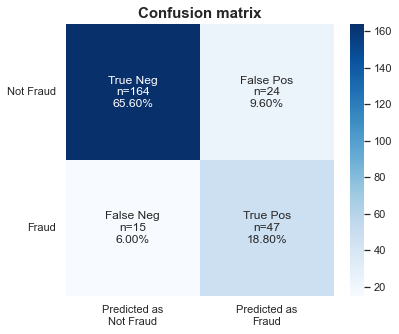

In [629]:
#confusion matrix
predictions = rs_xg.best_estimator_.predict(x_test)
cf_matrix = confusion_matrix(y_test, predictions)

#labels for the inside of heatmap
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['n={0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

#put them next line
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

#in array 2,2 cos the heatmap will be 2,2
labels = np.asarray(labels).reshape(2,2)

#class labeling
yticklabels=['Not Fraud','Fraud']
xticklabels=['Predicted as\nNot Fraud','Predicted as\nFraud']


# Set the default matplotlib figure size to 7x7:
fix, ax = plt.subplots(figsize=(6,5))

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
sns.set()
ax = sns.heatmap(cf_matrix, annot=labels, 
            xticklabels = xticklabels, yticklabels = yticklabels, 
            fmt='', cmap='Blues');

# Resize the labels.
ax.set_title('Confusion matrix', fontsize=15,  fontweight='bold')
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=11, ha= 'center', rotation=0 )
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=11, va="center", rotation=0);

In [631]:
import pickle
model_file_name = "xgb_best_model.pkl"
pickle.dump(rs_xgb2, open(model_file_name, "wb"))

preprocessor_file_name = "preprocessor_pipeline.pkl"
pickle.dump(preprocessor, open(preprocessor_file_name, "wb"))